# Sto learning 


In [1]:
import matplotlib.pyplot as plt
import dgl
from torch.utils.data import DataLoader
import torch
import time
import os
import sys
sys.path.insert(0, "../lib/")
import laplacian
import ninja
import sys
import utils
import model
import graphs
from utils import set_device
from laplacian import normalized_laplacian


# Autoreload
%load_ext autoreload
%autoreload 2

# GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

device = set_device(verbose=True)

cuda available


# MNIST Superpixel

In [2]:
from superpixels import SuperPixDataset
DATASET_NAME = 'MNIST'
dataset = SuperPixDataset(DATASET_NAME)  # 54s
trainset, valset, testset = dataset.train, dataset.val, dataset.test

[I] Loading dataset MNIST...
<_io.BufferedReader name='../Datasets/superpixels/MNIST.pkl'>
train, test, val sizes : 55000 10000 5000
[I] Finished loading.
[I] Data load time: 45.4431s


## Visualise the dataset

Label: tensor(4)
graph: DGLGraph(num_nodes=73, num_edges=584,
         ndata_schemes={'feat': Scheme(shape=(3,), dtype=torch.float16)}
         edata_schemes={'feat': Scheme(shape=(1,), dtype=torch.float16)})
Largest eigenvalue: 1.3723897027222667
Smallest eigenvalue: 1.1102230246251565e-16


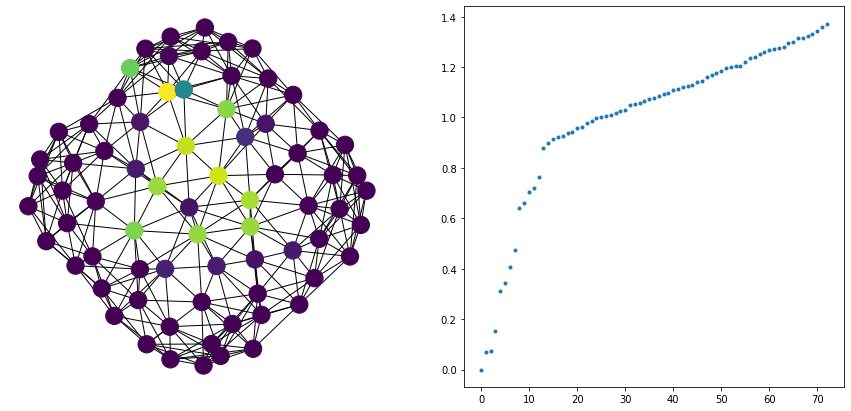

In [3]:
import networkx as nx
import random
from ninja import GeigplotL
plt.figure(figsize=(15,7))

plt.subplot(121)
g_demo, l_demo = trainset[random.randrange(45000)]
nx.draw_kamada_kawai(g_demo.to_networkx().to_undirected(),node_color=g_demo.ndata['feat'][:,0])
print('Label:',l_demo)
print('graph:',g_demo)

plt.subplot(122)
GeigplotL(g_demo)
plt.show()



# Model definition for training

In [4]:
from model import DGL_mean_Classifier, Classifier
# model_parameters
in_features = 1
first_conv_out = 50
second_conv_out = 150
hidden_layer_classifier = 250
k = 10
n_classes = 10

net = DGL_mean_Classifier(
    in_features, first_conv_out, second_conv_out, hidden_layer_classifier, n_classes, k
)

print(net)
if torch.cuda.is_available():
    net.to(device)

DGL_mean_Classifier(
  (layers): ModuleList(
    (0): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=1, out_features=50, bias=False)
        (1): Linear(in_features=1, out_features=50, bias=False)
        (2): Linear(in_features=1, out_features=50, bias=False)
        (3): Linear(in_features=1, out_features=50, bias=False)
        (4): Linear(in_features=1, out_features=50, bias=False)
        (5): Linear(in_features=1, out_features=50, bias=False)
        (6): Linear(in_features=1, out_features=50, bias=False)
        (7): Linear(in_features=1, out_features=50, bias=False)
        (8): Linear(in_features=1, out_features=50, bias=False)
        (9): Linear(in_features=1, out_features=50, bias=False)
      )
    )
    (1): ChebConv(
      (fc): ModuleList(
        (0): Linear(in_features=50, out_features=150, bias=False)
        (1): Linear(in_features=50, out_features=150, bias=False)
        (2): Linear(in_features=50, out_features=150, bias=False)
        (3): Line

In [5]:
from utils import load_model
#net.load_state_dict(load_model('Cheb_mean'))

# Training pipe

In [6]:
import torch.optim as optim
import torch.nn as nn
#
from utils import collate, collate2
#

train_loader = DataLoader(trainset, batch_size=2048,
                         shuffle=True, collate_fn=collate2, drop_last=True, pin_memory=False)
val_loader =  DataLoader(valset, batch_size=1000,
                         shuffle=False, collate_fn=collate2, drop_last=True, pin_memory=False)
test_loader =  DataLoader(testset, batch_size=1000,
                         shuffle=False, collate_fn=collate2, drop_last=True, pin_memory=True)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.99)

epoch_losses = []

, (torch.ones(2048)*1.4).to(device)

In [7]:
def train(model, device, data_loader, epochs, loss_func, optimizer, scheduler):

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        t0 = time.time()

        for iter, (data, label) in enumerate(data_loader):
            data, label = data.to(device), label.to(device)

            output = model(data, 
                           data.ndata.pop('feat')[:, 0].float().to(device),
                           (torch.ones(2048)*2).to(device))
            loss = loss_func(output, label.to(device))

            # sum up batch loss
            epoch_loss += loss.detach().item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

        epoch_loss /= iter + 1

        #print('\n Average loss per epoch: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        #    epoch_loss, correct, len(test_loader.dataset),
        #    100. * correct / len(test_loader.dataset)))

        val_loss = test(net, device, val_loader, False)

        scheduler.step()

        print(
            "Epoch {}, loss - train {:.4f} - val {:.4f} -- Accuracy: {}/{} ({:.0f}%) in {:.2f}(s) ".format(
                epoch, epoch_loss, val_loss, correct, len(data_loader.dataset),
            100. * correct / len(data_loader.dataset), time.time() - t0
            )
        )
        epoch_losses.append([epoch_loss, val_loss])

In [8]:
def test(model, device, data_loader, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    tot_label = []
    tot_pred = []

    with torch.no_grad():
        for iter, (data, label) in enumerate(data_loader):
            data, label = data.to(device), label.to(device)

            output = model(data, data.ndata.pop('feat')[
                           :, 0].float(), (torch.ones(1000)*2).to(device))
            # sum up batch loss
            test_loss += loss_func(output, label.to(device)).item()

            # get the index of the max log-probability
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(label.view_as(pred)).sum().item()

            tot_label.append(label.cpu())
            tot_pred.append(pred.cpu())

    # for the classification report
    tot_label = torch.stack(tot_label).view(-1).cpu()
    tot_pred = torch.stack(tot_pred).view(-1).cpu()

    test_loss /= iter + 1

    if verbose:
        print('\n Average loss per epoch: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

        # BATCHED DGL EXAMPLE
        import sklearn
        from sklearn.metrics import classification_report

        print(sklearn.metrics.classification_report(tot_label, tot_pred))

    else:
        return test_loss

## Training time

In [9]:
train(net, device, train_loader, 15, loss_func,optimizer, scheduler)

Epoch 0, loss - train 3.0152 - val 2.0624 -- Accuracy: 8847/55000 (16%) in 18.73(s) 
Epoch 1, loss - train 2.0414 - val 1.9646 -- Accuracy: 13443/55000 (24%) in 18.15(s) 
Epoch 2, loss - train 1.9771 - val 1.9198 -- Accuracy: 14769/55000 (27%) in 18.15(s) 
Epoch 3, loss - train 1.9557 - val 1.9159 -- Accuracy: 15220/55000 (28%) in 17.98(s) 
Epoch 4, loss - train 1.9450 - val 1.9031 -- Accuracy: 15436/55000 (28%) in 17.81(s) 
Epoch 5, loss - train 1.9309 - val 1.8944 -- Accuracy: 15612/55000 (28%) in 17.76(s) 
Epoch 6, loss - train 1.9275 - val 1.8849 -- Accuracy: 15807/55000 (29%) in 18.14(s) 
Epoch 7, loss - train 1.9205 - val 1.8797 -- Accuracy: 15833/55000 (29%) in 17.66(s) 
Epoch 8, loss - train 1.9225 - val 1.8780 -- Accuracy: 15888/55000 (29%) in 18.25(s) 
Epoch 9, loss - train 1.9124 - val 1.8837 -- Accuracy: 16146/55000 (29%) in 17.93(s) 
Epoch 10, loss - train 1.9121 - val 1.8783 -- Accuracy: 16058/55000 (29%) in 19.68(s) 
Epoch 11, loss - train 1.9048 - val 1.8742 -- Accuracy

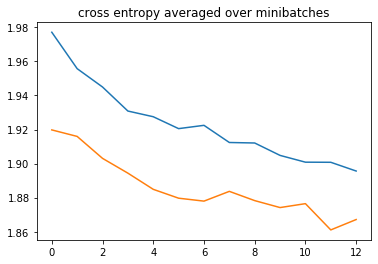

In [10]:
plt.title("cross entropy averaged over minibatches")
plt.plot(epoch_losses[2:])
plt.show()

In [11]:
torch.cuda.empty_cache()

## Test Metrics

In [12]:
test(net,device,test_loader)


 Average loss per epoch: 1.8632, Accuracy: 3196/10000 (32%)

              precision    recall  f1-score   support

           0       0.38      0.70      0.49       980
           1       0.59      0.81      0.69      1135
           2       0.18      0.06      0.09      1032
           3       0.18      0.19      0.19      1010
           4       0.18      0.05      0.08       982
           5       0.19      0.06      0.09       892
           6       0.24      0.16      0.19       958
           7       0.27      0.33      0.29      1028
           8       0.27      0.49      0.35       974
           9       0.26      0.26      0.26      1009

    accuracy                           0.32     10000
   macro avg       0.27      0.31      0.27     10000
weighted avg       0.28      0.32      0.28     10000



## Saving

In [13]:
from utils import save_model

save_model("Cheb_mean", net)